In [1]:
%matplotlib widget

import os
import sys

sys.path.insert(0, os.getenv("HOME") + "/pycode/MscThesis/")
from pymatreader import read_mat
from scipy import sparse
import numpy as np
import os
from datetime import datetime, timedelta
import pandas
from amftrack.pipeline.functions.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    sparse_to_doc,
)
import cv2
import json
import pandas as pd
from amftrack.pipeline.paths.directory import *
from amftrack.util.sys import *
from amftrack.pipeline.functions.extract_observable import *
import pickle
from joblib import Parallel, delayed
from datetime import datetime
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'amftrack.pipeline.functions.extract_graph'

In [2]:
directory = directory_project
update_analysis_info(directory)
analysis_info = get_current_analysis(directory)

In [75]:
%load_ext autoreload
%autoreload 2
import sys
from amftrack.util.sys import (
    update_analysis_info,
    get_analysis_info,)
from amftrack.pipeline.launching.run_super import run_parallel_post
from amftrack.pipeline.functions.post_processing.global_plate import *
from amftrack.pipeline.functions.post_processing.time_plate import *
from amftrack.pipeline.functions.post_processing.global_hypha import *
from amftrack.pipeline.functions.post_processing.area_hulls import *
from amftrack.pipeline.launching.run_super import run_parallel,run_launcher
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    load_graphs,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from random import choice
from amftrack.util.geometry import (
    centered_bounding_box
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    plot_hulls_skelet,
    plot_full,
    plot_edge_width
    

)
directory = os.path.join(directory_scratch,'stitch_temp')+'/'
update_analysis_info(directory)
analysis_info = get_analysis_info(directory)
plates = ['1053_20220413']
select = analysis_info.loc[analysis_info['unique_id'].isin(plates)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
path_exp = f'{directory}{select["path_exp"].iloc[0]}'
exp = pickle.load(open(path_exp, "rb"))

In [45]:
not exp.nx_graph is None

False

In [46]:
def load_graphs(exp, indexes=None,reload=True):
    #TODO : add as a class method
    nx_graph_poss = []
    labeled = exp.labeled
    if indexes == None:
        indexes = range(exp.ts)
    for index, date in enumerate(exp.dates):
        directory_name = get_dirname(date, exp.folders)
        path_snap = exp.directory + directory_name
        if labeled:
            suffix = "/Analysis/nx_graph_pruned_labeled.p"
        else:
            suffix = "/Analysis/nx_graph_pruned.p"
        path_save = path_snap + suffix
        if (reload and index in indexes) or (exp.nx_graph is None):
            (g, pos) = pickle.load(open(path_save, "rb"))
        else:
            (g, pos) = exp.nx_graph[index],exp.positions[index]
        if index in indexes:
            nx_graph_poss.append((g, pos))
        else:
            edge_empty = {edge: None for edge in g.edges}
            nx.set_edge_attributes(g, edge_empty, "pixel_list")
            nx_graph_poss.append((g, pos))
    nx_graphs = [nx_graph_pos[0] for nx_graph_pos in nx_graph_poss]
    poss = [nx_graph_pos[1] for nx_graph_pos in nx_graph_poss]
    #         nx_graph_clean=[]
    #         for graph in nx_graphs:
    #             S = [graph.subgraph(c).copy() for c in nx.connected_components(graph)]
    #             len_connected=[len(nx_graph.nodes) for nx_graph in S]
    #             nx_graph_clean.append(S[np.argmax(len_connected)])
    exp.positions = poss
    exp.nx_graph = nx_graphs

In [69]:
t=19
nodes = [
        node
        for node in exp.nodes
        if node.is_in(t) and np.all(is_in_study_zone(node, t, 1000, 200))
]
tips = [
    node
    for node in nodes
    if node.degree(t) == 1 and node.is_in(t + 1) and len(node.ts()) > 2
]
growing_tips = [
    node
    for node in tips
    if np.linalg.norm(node.pos(t) - node.pos(node.ts()[-1])) >= 40
]
growing_rhs = [
    node
    for node in growing_tips
    if np.linalg.norm(node.pos(node.ts()[0]) - node.pos(node.ts()[-1])) >= 300
]
anas_tips = [
    tip
    for tip in growing_rhs
    if tip.degree(t) == 1
    and tip.degree(t + 1) == 3
    and 1 not in [tip.degree(t) for t in [tau for tau in tip.ts() if tau > t]]
]
anas_tips

[Node(6455),
 Node(7416),
 Node(7504),
 Node(8166),
 Node(8940),
 Node(9349),
 Node(10350)]

In [67]:
ts = [t,t+1,t+3]
load_graphs(exp, indexes=ts,reload=True)
load_study_zone(exp)
for t in ts:
    exp.load_tile_information(t)

In [72]:
node = choice(anas_tips)


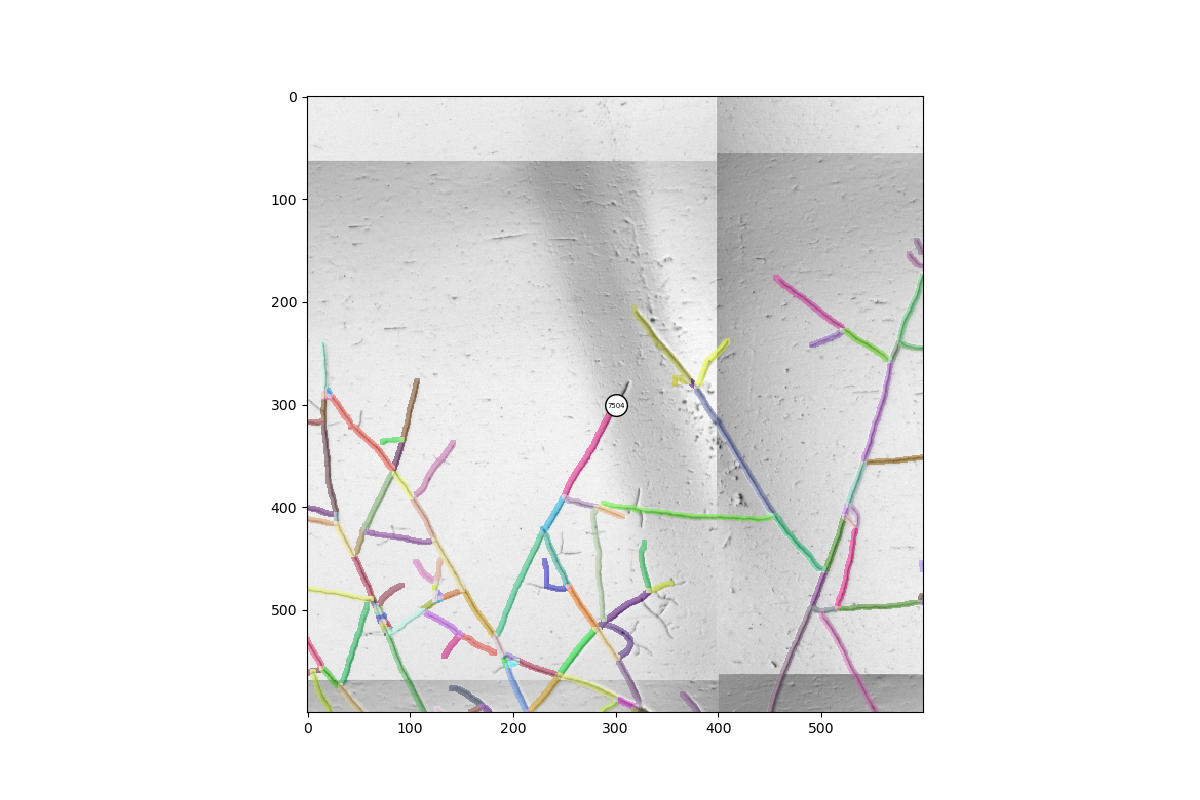

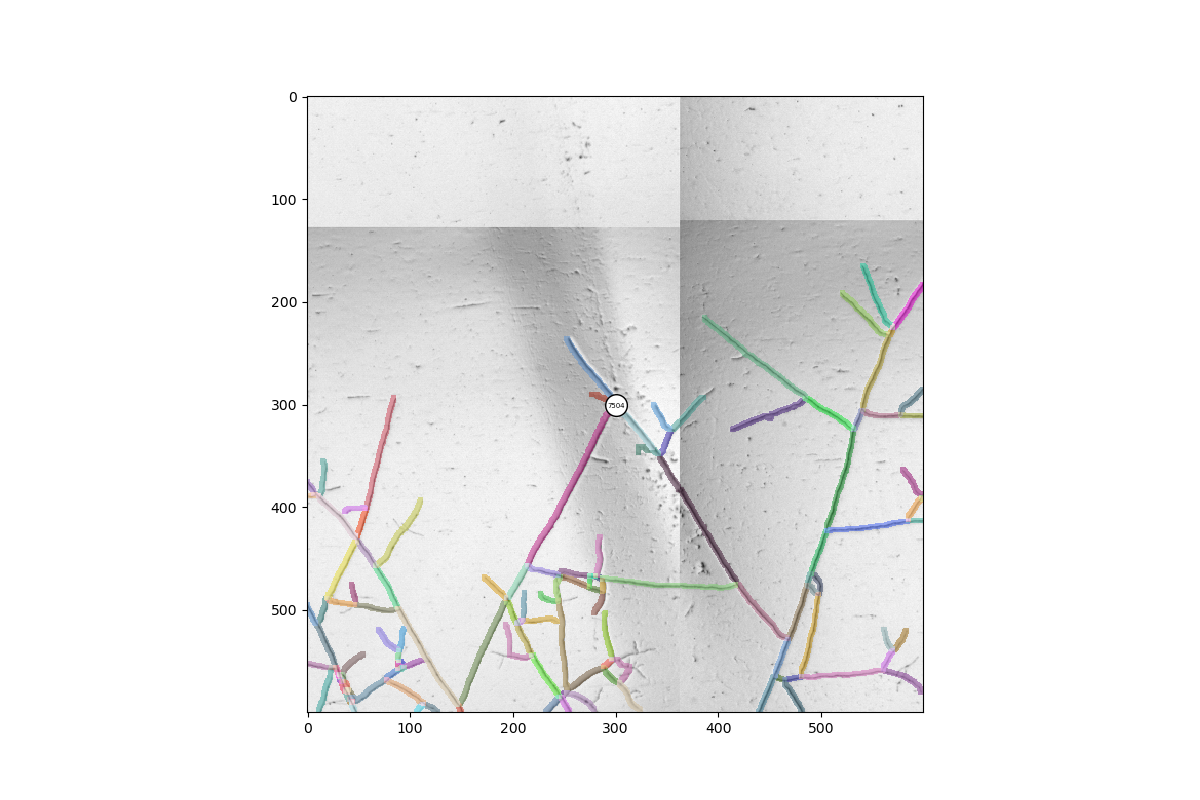

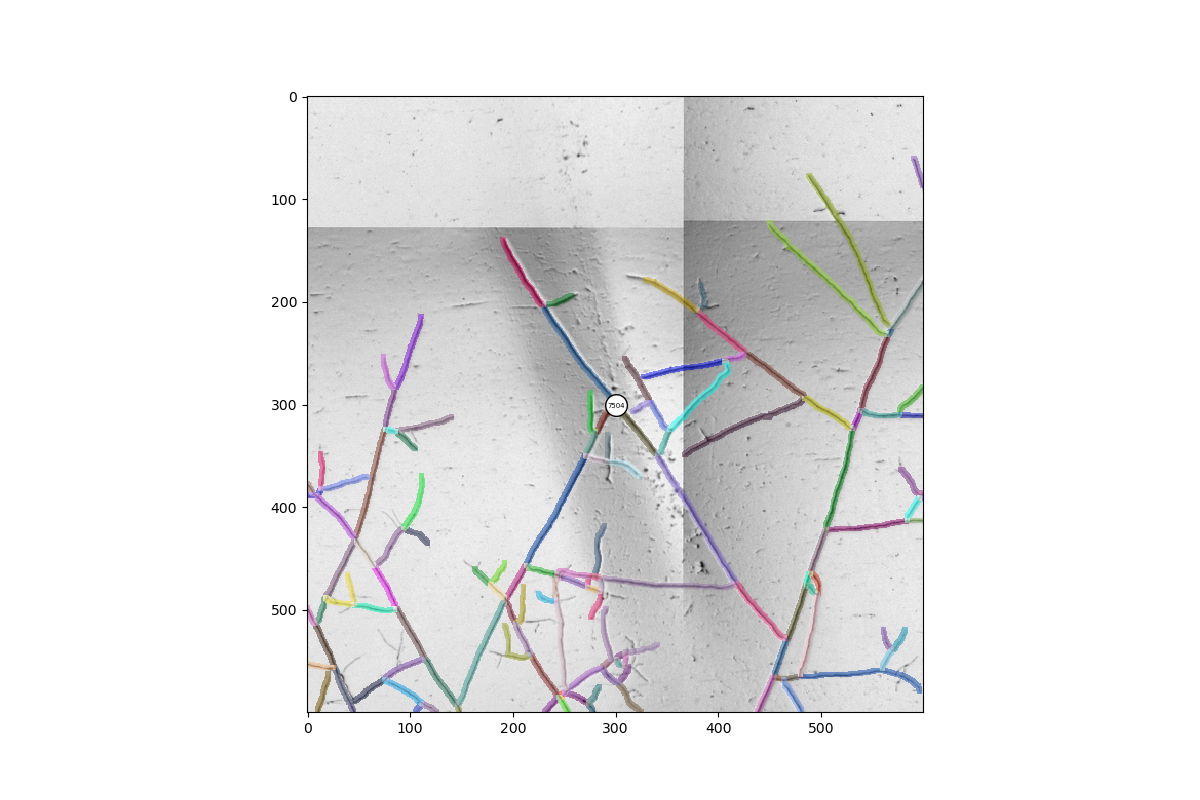

In [81]:
%matplotlib widget

for t in ts:
    pos = node.pos(t)
    region = centered_bounding_box(pos, size=3000)
    # region = centered_bounding_box(pos, size=3000)
    plot_full(
        exp,
        t,
        region=region,
        downsizing=5,
        nodes=[node],
        edges=get_all_edges(exp, t),
        dilation=5,
        prettify=False,
        # save_path=os.path.join(test_path, "test_region_centered"),
    )

In [41]:
t = 13
pos = node.pos(t)
region = centered_bounding_box(pos, size=3000)
# region = centered_bounding_box(pos, size=3000)
plot_full(
    exp,
    t,
    region=region,
    downsizing=5,
    nodes=[node],
    edges=get_all_edges(exp, t),
    dilation=5,
    prettify=False,
    #save_path=os.path.join(test_path, "test_region_centered"),
)

TypeError: 'NoneType' object is not iterable

In [5]:
plates = set(select_v7["Plate"].values)
plates
selection = []
for plate in plates:
    select_folder = np.min(
        select_v7.loc[(select_v7["Plate"] == plate)]["folder_analysis"]
    )
    selection.append(select_folder)
select = select_v7.loc[(select_v7["folder_analysis"].isin(selection))]

Analysis_1635803385128979235_Version7
Analysis_1635803714847232986_Version7


/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


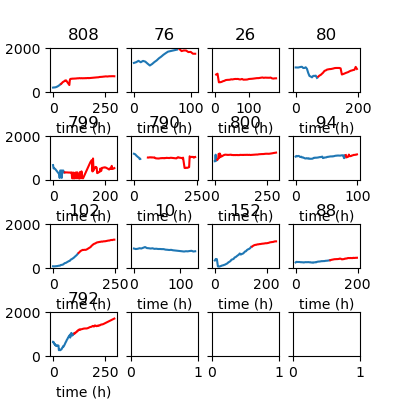

In [50]:
import warnings

warnings.filterwarnings("ignore", category=plt.cbook.mplDeprecation)
plt.close("all")
x = "time_since_begin"
y = "density"
xlabel = "time (h)"
ylabel = "densitu"
logy = False
logx = False
ylim = 0, 2000
num_columns = 4
num_rows = len(select) // num_columns + 1
fig = plt.figure(figsize=(num_columns * 1, num_rows * 1))
gs = fig.add_gridspec(num_rows, num_columns, hspace=1)
axs = gs.subplots(sharex=False, sharey=True)
axs = axs.flatten()
i = 0
for index, row in select.iterrows():
    folder = row["folder_analysis"]
    path_analysis_info = row["path_analysis_info"]
    plate = row["Plate"]
    if os.path.isfile(f"{directory}{path_analysis_info}"):
        ax = axs[i]
        whole_plate_info = pd.read_json(
            f"{directory}{path_analysis_info}", convert_dates=True
        ).transpose()
        whole_plate_info.index.name = "t"
        whole_plate_info.reset_index(inplace=True)
        whole_plate_info["datetime"] = pd.to_datetime(
            whole_plate_info["date"], format="%d.%m.%Y, %H:%M:"
        )
        whole_plate_info["time_since_begin"] = (
            whole_plate_info["datetime"] - min(whole_plate_info["datetime"])
        ) / np.timedelta64(1, "h")
        whole_plate_info["density"] = (
            whole_plate_info["tot_length_study"] / whole_plate_info["area_study"]
        )
        in_study = whole_plate_info.loc[whole_plate_info["out_study"] == 0]
        out_study = whole_plate_info.loc[whole_plate_info["out_study"] == 1]
        if len(in_study) > 0:
            in_study.plot(
                x, y, title=plate, ax=ax, logy=logy, logx=logx, ylim=ylim, legend=False
            )
        if len(out_study) > 0:
            out_study.plot(
                x,
                y,
                title=plate,
                ax=ax,
                color="red",
                logx=logx,
                logy=logy,
                ylim=ylim,
                legend=False,
            )
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        i += 1
    else:
        print(folder)
plt.tight_layout(pad=1, w_pad=1, h_pad=1)